###**Proposed tasks (distribute between channels)**
- Search for more datasets (reports) and external data (nearby police station, hospitals, toilets, quality of street lights about an area info; data related to public transport and connection with cab services...)
- Pre-processing (remove and make up)
- Clustering geography into heatmap of safe and unsafe
- Color areas based on the difference in their safety level based on reports density, quality of issues, external data (Cloropeth graph)
- Time-Series plot
- Find similar areas in other parts of the world: Build a predictor
- NLP to get insights about 'DESCRIPTION' column
- Raise automated safety tips or warnings about certain areas based on studying data trends.
- Find the fastest way to reach a safe place in case of an emergency (weight several options and decide the best)
- Gather all in a product
###**Proposed channels**
- Data-Mining and preprocessing (build project's dataset)
- Data Visualization
- Risk score predictor
- Safety Tips and Warnings
- Natural Language Processing
- Emergency route planner

In [1]:
# install and upgrade dependencies
!pip install -U -q PyDrive
!pip install --upgrade pandas

     |████████████████████████████████| 993kB 4.3MB/s 
     |████████████████████████████████| 10.5MB 4.8MB/s 
     |████████████████████████████████| 235kB 38.7MB/s 
ERROR: google-colab 1.0.0 has requirement pandas~=0.24.0, but you'll have pandas 0.25.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: python-dateutil 2.5.3
    Uninstalling python-dateutil-2.5.3:
      Successfully uninstalled python-dateutil-2.5.3
  Found existing installation: pandas 0.24.2
    Uninstalling pandas-0.24.2:
      Successfully uninstalled pandas-0.24.2


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import numpy as np
import pandas as pd
import folium
from folium import plugins
from folium.plugins import HeatMap, MousePosition, Fullscreen, FeatureGroupSubGroup, MeasureControl
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [0]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download csv from drive link using id and save to Filename.csv
link = 'https://drive.google.com/open?id=1y68Lam5UHHjYA1_PibTzrerEMlI9OmYd'
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id})
dataset_filename = 'Safecity_Report_28072019.csv'
downloaded.GetContentFile(dataset_filename)

# Load DataFrame from csv and print overview and row sample
df = pd.read_csv('Safecity_Report_28072019.csv')

In [107]:
df.head()

,#,INCIDENT TITLE,INCIDENT DATE,LOCATION,DESCRIPTION,LATITUDE,LONGITUDE,More Info
0,12152,touching,27-05-2019 15:00,"Chanakya Puri, Danapur Nizamat, Patna, Bihar 8...",My school auto driver always use to stare at m...,25.625485,85.055803,NaN
1,12149,whistling,17-05-2019 19:00,"Near Nissan Showroom, Bailey Rd, Patna, Bihar ...",I was in market with my mom. There I saw a man...,25.619769,85.045596,NaN
2,12213,sexual invite,15-05-2019 15:03,"Makina, Nairobi, Kenya",there is a girl whom boys have been writing a ...,-1.308482,36.789595,NaN
3,12199,sexual invite,14-05-2019 14:13,"Makina, Nairobi, Kenya",there is a girl who is being disturbed y a bo...,-1.308482,36.789595,NaN
4,12206,sexual invite,13-05-2019 14:45,"Makina, Nairobi, Kenya",there are some boys who likes disturbing a gir...,-1.308482,36.789595,NaN


In [4]:
#Check the number of rows without a location (value==NaN)
print('Shape of df : ', df.shape)
print('More_Info column number of NaN values : ', df['More Info'].isna().sum())
print('Latitude column number of NaN values : ', df.LATITUDE.isna().sum())
print('Longitude column number of NaN values : ', df.LONGITUDE.isna().sum())

df = pd.read_csv('Safecity_Report_28072019.csv')

print('\nDropping rows without location.....\n')

df = df[pd.notna(df['LONGITUDE'])]
print('New shape of df : ', df.shape)

#From string comma-separated to boolean
categories=[]
counter = 0

for index, row in tqdm(df.iterrows()):
    counter+=1
    cat_group_list = [i for i in row.CATEGORY.split(',')]
    del(cat_group_list[-1])
    for category in cat_group_list:
      category = [category.lstrip()]
      if category not in categories:
        categories.append(category) #add a new category
      else:
        next
    #replace in the original df with the list. iat[] is to set a single row and 5 is the CATEGORY column index    
    df.iat[index, 5] = cat_group_list
    
print("Total number of unique categories : {}\n".format(len(categories)))
counts = [0] * len(categories)

#Now I want to pass the list in CATEGORY to a vector of 1s and 0s
categories_bool = [[]]
category_bool = [0]*len(categories)

for index, row in df.iterrows():
  row_category = row['CATEGORY']
  for category in row_category:
    index_match = list(filter(lambda x: categories[x][0] == category.lstrip(), range(len(categories))))
    category_bool[index_match[0]] = 1
  categories_bool.append(category_bool)
  category_bool = [0]*len(categories)
del(categories_bool[0])

#Expand the column CATEGORY by its boolean representation
category_list = [cat[0] for cat in categories]
df_categories = pd.DataFrame.from_records(categories_bool)
df_categories.columns = category_list
df_ready = pd.concat([df, df_categories], axis=1)

Shape of df :  (11691, 9)
More_Info column number of NaN values :  11518
Latitude column number of NaN values :  0
Longitude column number of NaN values :  0

Dropping rows without location.....

New shape of df :  (11691, 9)



Total number of unique categories : 14



In [110]:
df_ready.head()

,#,INCIDENT TITLE,INCIDENT DATE,LOCATION,DESCRIPTION,CATEGORY,LATITUDE,LONGITUDE,More Info,Touching /Groping,Catcalls/Whistles,Sexual Invites,Stalking,Others,Commenting,Rape / Sexual Assault,North East India Report,Indecent exposure,Chain Snatching,Ogling/Facial Expressions/Staring,Taking pictures,Poor / No Street Lighting,Online Harassment
0,12152,touching,27-05-2019 15:00,"Chanakya Puri, Danapur Nizamat, Patna, Bihar 8...",My school auto driver always use to stare at m...,[Touching /Groping],25.625485,85.055803,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,12149,whistling,17-05-2019 19:00,"Near Nissan Showroom, Bailey Rd, Patna, Bihar ...",I was in market with my mom. There I saw a man...,[Catcalls/Whistles],25.619769,85.045596,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,12213,sexual invite,15-05-2019 15:03,"Makina, Nairobi, Kenya",there is a girl whom boys have been writing a ...,[Sexual Invites],-1.308482,36.789595,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,12199,sexual invite,14-05-2019 14:13,"Makina, Nairobi, Kenya",there is a girl who is being disturbed y a bo...,[Sexual Invites],-1.308482,36.789595,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,12206,sexual invite,13-05-2019 14:45,"Makina, Nairobi, Kenya",there are some boys who likes disturbing a gir...,[Sexual Invites],-1.308482,36.789595,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0


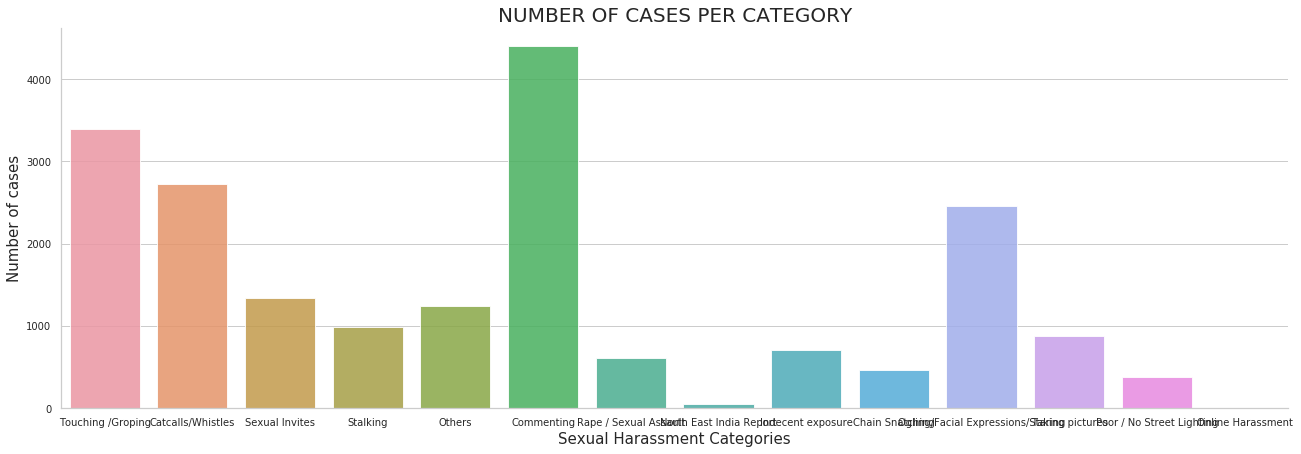

,0
3396,Touching /Groping
2729,Catcalls/Whistles
1343,Sexual Invites
993,Stalking
1248,Others
4404,Commenting
613,Rape / Sexual Assault
49,North East India Report
712,Indecent exposure
469,Chain Snatching


In [5]:
# Calculate number of incidents per category
totals = df_ready.sum(axis=0)[7:]
# Configure a seaborn barplot
sns.set(style="whitegrid")
fig, ax = plt.subplots()
fig.set_size_inches(22, 7)
category_plot = sns.barplot(x=totals.index.to_list(), y=totals.values, alpha=0.85)
category_plot.axes.set_title("NUMBER OF CASES PER CATEGORY",fontsize=20)
category_plot.set_xlabel("Sexual Harassment Categories",fontsize=15)
category_plot.set_ylabel("Number of cases",fontsize=15)
category_plot.tick_params(labelsize=10)
sns.set(font_scale=3)
sns.despine()
plt.show()
# Create and show totals DataFrame
totals_df = pd.DataFrame(totals.index.to_list(), totals.values.tolist())
totals_df
# Human trafficking and petty robbery dont have location column

In [6]:
  colors = ['blue', 'green', 'purple', 'orange', 'pink', 'beige', 'cadetblue',
            'gray', 'white', 'black', 'lightblue', 'lightgray', 'lightgreen', 'red']
  
categories_color_dic = {index: value for (index, value) in zip(totals.index.to_list(), colors)}
print(categories_color_dic)

{'Touching /Groping': 'blue', 'Catcalls/Whistles': 'green', 'Sexual Invites': 'purple', 'Stalking': 'orange', 'Others': 'pink', 'Commenting': 'beige', 'Rape / Sexual Assault': 'cadetblue', 'North East India Report': 'gray', 'Indecent exposure': 'white', 'Chain Snatching': 'black', 'Ogling/Facial Expressions/Staring': 'lightblue', 'Taking pictures': 'lightgray', 'Poor / No Street Lighting': 'lightgreen', 'Online Harassment': 'red'}


In [7]:
categories_color_dic

{'Catcalls/Whistles': 'green',
 'Chain Snatching': 'black',
 'Commenting': 'beige',
 'Indecent exposure': 'white',
 'North East India Report': 'gray',
 'Ogling/Facial Expressions/Staring': 'lightblue',
 'Online Harassment': 'red',
 'Others': 'pink',
 'Poor / No Street Lighting': 'lightgreen',
 'Rape / Sexual Assault': 'cadetblue',
 'Sexual Invites': 'purple',
 'Stalking': 'orange',
 'Taking pictures': 'lightgray',
 'Touching /Groping': 'blue'}

In [0]:
def draw_map(data, location_start=[0,0], zoom_start=3, tiles='OpenStreetMap', split=False, color='red'): 
  markers = []
  fmtr = "function(num) {return L.Util.formatNum(num, 3) + ' º ';};"
  new_map = folium.Map(location=location_start, zoom_start=zoom_start, tiles=tiles)
  if type(data) is int:
    return new_map
  if split:
    fg = folium.plugins.MarkerCluster(control=True)
    new_map.add_child(fg) 
    groups = [FeatureGroupSubGroup(fg, category) for category in category_list]
  for index, harassment_case in tqdm(data.iterrows()):
    if split:
      for group in groups:
        new_map.add_child(group)       
      for cat in harassment_case['CATEGORY']:
        color = categories_color_dic[cat.lstrip()]
        marker = folium.Marker([harassment_case['LATITUDE'], harassment_case['LONGITUDE']], 
                                popup=harassment_case['INCIDENT TITLE'], 
                                tooltip=harassment_case['INCIDENT DATE'],
                                icon=folium.Icon(color=color, icon='info-sign'))
        marker.add_to(groups[category_list.index(cat.lstrip())])
        markers.append(marker)
      continue
    marker = folium.Marker([harassment_case['LATITUDE'], harassment_case['LONGITUDE']], 
                                popup=harassment_case['INCIDENT TITLE'], 
                                tooltip=harassment_case['INCIDENT DATE'],
                                icon=folium.Icon(color=color, icon='info-sign'))
    marker.add_to(new_map)
    markers.append(marker)
  folium.LayerControl(collapsed=False).add_to(new_map)
  MousePosition(position='topright', separator=' | ', prefix="Mouse:", lat_formatter=fmtr, lng_formatter=fmtr).add_to(new_map)
  Fullscreen(position='topleft', title='Full Screen', title_cancel='Exit Full Screen', force_separate_button=False).add_to(new_map)
  return new_map, markers

In [232]:
def marker_params(sample):
  params = sample+"['LATITUDE'], "+sample+"['LONGITUDE']], popup="+sample+"['INCIDENT TITLE'], tooltip="+sample+"['INCIDENT DATE'], icon=folium.Icon(color=color, icon='info-sign')"
  return params

out = marker_params('iterator_name')
print(out)

iterator_name['LATITUDE'], iterator_name['LONGITUDE']], popup=iterator_name['INCIDENT TITLE'], tooltip=iterator_name['INCIDENT DATE'], icon=folium.Icon(color=color, icon='info-sign')


In [236]:
df_test_1 = df_ready.iloc[:,:]
test_map, test_markers = draw_map(df_test_1, split=True) 
# In order to filter per category I just filter the dataset: df_cat1 = df_test_1[df_test_1['Touching /Groping'] == 1]
test_map.save('clustering.html') #Some maps won't display in notebook so I save the html instead
print('Done.')


Done.


In [133]:
datamap_test, markers = draw_map(df_ready.iloc[0:1000,:], zoom_start=2, split=True)
datamap_test.save('datamap_test.html')
print('Done.')


Done.


In [9]:
#HeatMap for density report
heat = draw_map(1, zoom_start=2)
heat_data = [[row['LATITUDE'], row['LONGITUDE']] for index, row in df_ready.iterrows()]
HeatMap(heat_data, gradient={.4: 'blue', .65: 'lime', 1: 'red'}).add_to(heat)

fmtr = "function(num) {return L.Util.formatNum(num, 3) + ' º ';};"
MousePosition(position='topright', separator=' | ', prefix="Mouse:", lat_formatter=fmtr, lng_formatter=fmtr).add_to(heat)
Fullscreen(position='topleft', title='Full Screen', title_cancel='Exit Full Screen', force_separate_button=False).add_to(heat)
heat.save('map_test.html')
heat

###**RISK FUNCTION DEFINITION**
It will be defined first in a supervised fashion, using the features that we already have, otherS that we could create or external information. It can be done initially without considering the description.

In [67]:
type(df_ready)

pandas.core.frame.DataFrame

In [0]:
#TO DO:: (for the first task)
# add or create more feature that will help to create the risk score an define the function
# For the function consider the number of reported cases in an area, that's the density bla..
# graph per category
# calculate sector statistics (also helpful for the risk score) and define what happens when clicking a cluster